##Libraries and constants

In [0]:
# default import, might be useless

# deep learning library
import torch
import torchvision
from   torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# to import data
import torchvision.transforms as transforms 
import torchvision.datasets.mnist as mnist  

# we use torch.cuda.Event(enable_timing=True) to measure time
# if you don't have cuda, you can use instead :
# from timeit import default_timer as timer
# import time

import collections           # for ordered_dictionnary
import torch.nn.init as init # to initialize model

import copy # for copy.deepcopy( ... )

import numpy as np

# to make and display plots
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 

# to allow for aggregate data points
import matplotlib
matplotlib.use('Agg')

# to format time to strings
import datetime                      

import math # for ceil ()

import IPython.display # to display .png

import time
import collections
import os
import sys
import torch
import torch.nn
from torch.autograd import Variable
import torch.nn as nn

from torch.distributions.normal import Normal
from torchvision.utils import *

import torch
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import dataset
from torch import nn
# from torch.nn.modules import upsampling
# from torch.functional import F
from torch.optim import Adam

# Use the GPU if you have one
if torch.cuda.is_available():
    print("Using the GPU")
    device = torch.device("cuda") 
else:
    print("WARNING: You are about to run on cpu")
    device = torch.device("cpu")
    
# hyperparam :
LAMBDA = 10
EPOCHS = 100
CRITIC_ITERS = 5    # How many critic iterations per generator iteration
OUTPUT_DIM   = 3072 # Number of pixels in SVHN (3*32*32)
BATCH_SIZE   = 64
DIM          = 100  # latent dimension

ALPHA  = 0 # ponderation of classification loss in the critics network
PAC = 4 # PacGAN

verbose  = True

Using the GPU


##Logging functions:

In [0]:
try:
    import cPickle as pickle
except:
    import pickle

_since_beginning = collections.defaultdict(lambda: {})
_since_last_flush = collections.defaultdict(lambda: {})

_iter = [0]
def tick():
	_iter[0] += 1

def log(name, value):
	_since_last_flush[name][_iter[0]] = value

def flush():
	prints = []

	for name, vals in _since_last_flush.items():
		prints.append("{}\t{}".format(name, np.mean(list(vals.values()))))
		_since_beginning[name].update(vals)

		x_vals = np.sort(list(_since_beginning[name].keys()))
		y_vals = [_since_beginning[name][x] for x in x_vals]
    
		plt.figure()
		plt.clf()
		plt.plot(x_vals, y_vals)
		plt.xlabel('iteration')
		plt.ylabel(name)
		plt.savefig("GAN_save/"+name.replace(' ', '_')+'.jpg')

	print("iter {}\t{}".format(_iter[0], "\t".join(prints)) )
	_since_last_flush.clear()

	with open('log.pkl', 'wb') as f:
		pickle.dump(dict(_since_beginning), f, pickle.HIGHEST_PROTOCOL)

##Dataset processing:

In [0]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5),
                         (.5, .5, .5))
])


def get_data_loader(dataset_location, batch_size, drop_last=True):
    trainvalid = torchvision.datasets.SVHN(
        dataset_location, split='train',
        download=True,
        transform=image_transform
    )

    trainset_size = int(len(trainvalid) * 0.9)
    trainset, validset = dataset.random_split(
        trainvalid,
        [trainset_size, len(trainvalid) - trainset_size]
    )

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        drop_last=drop_last
    )

    validloader = torch.utils.data.DataLoader(
        validset,
        batch_size=batch_size,
        drop_last=drop_last
    )

    testloader = torch.utils.data.DataLoader(
        torchvision.datasets.SVHN(
            dataset_location, split='test',
            download=True,
            transform=image_transform
        ),
        batch_size=batch_size,
        drop_last=drop_last
    )

    return trainloader, validloader, testloader

##Explored Generators and Critics

In [0]:
# define decoder (generator) and critics (without batchnorm, with no sigmoid)

class UnFlatten(nn.Module):
    def __init__(self, n_channel=16, p_size=8 ):
        super(UnFlatten, self).__init__()
        self.n_channel = n_channel
        self.p_size    = p_size
        
    def forward(self, input):
        return input.view(input.size(0), self.n_channel, self.p_size, self.p_size).contiguous()

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, input):
        return input.view(input.size(0), -1).contiguous()


def make_openai_critic(ndf1, ndf2, ndf3, ndf4, drop_p=0.5):
    critic = nn.Sequential(
        # bs : batch size 
        
        # input is bs x (3) x 32 x 32
        nn.utils.weight_norm(nn.Conv2d(3, ndf1, 3, stride=1, padding=1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        # state size. bs x (ndf1) x 32 x 32
        nn.utils.weight_norm(nn.Conv2d(ndf1, ndf1, 3, 1, 1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        # state size. bs x (ndf1) x 32 x 32
        nn.utils.weight_norm(nn.Conv2d(ndf1, ndf2, 3, 1, 1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        torch.nn.MaxPool2d(2),
        
        nn.Dropout(drop_p),
        
        # input is    bs x (ndf2) x 16 x 16
        nn.utils.weight_norm(nn.Conv2d(ndf2, ndf2, 3, stride=1, padding=1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        # state size. bs x (ndf3) x 16 x 16
        nn.utils.weight_norm(nn.Conv2d(ndf2, ndf2, 3, 1, 1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        # state size. bs x (ndf2) x 16 x 16
        nn.utils.weight_norm(nn.Conv2d(ndf2, ndf3, 3, 1, 1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        torch.nn.MaxPool2d(2),
        
        nn.Dropout(drop_p),
        
        # state size. bs x (ndf3) x 8 x 8
        nn.utils.weight_norm(nn.Conv2d(ndf3, ndf3, 3, 1, 1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        torch.nn.MaxPool2d(2),
        # state size. bs x (ndf3) x 4 x 4
        nn.utils.weight_norm(nn.Conv2d(ndf3, ndf3, 3, 1, 1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        torch.nn.MaxPool2d(2),
        # state size. bs x (ndf3) x 2 x 2
        nn.utils.weight_norm(nn.Conv2d(ndf3, ndf4, 3, 1, 1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        
        Flatten(),
        # state size. bs x (ndf4x2x2)
        nn.utils.weight_norm( nn.Linear(ndf4*2*2, 1) ),
        # state size. bs x (1)
        )
    return critic
    
def make_GAN_decoder(z_dim=100,ngf=64,nc=3):
    decoder = nn.Sequential(
            # input is Z, going into a convolution
            UnFlatten(z_dim,1),
            nn.ConvTranspose2d(z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.Conv2d( ngf, nc, 5, stride=1, padding=2, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )
    return decoder

def make_GAN_critic(ndf=64,nc=3):
    decoder = nn.Sequential(
        # bs : batch size 
        # input is bs x (nc) x 32 x 32
        nn.Conv2d(nc, ndf, 5, stride=1, padding=2, bias=False),
        nn.ReLU(inplace=True),
        # state size. bs x (ndf) x 32 x 32
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.ReLU(inplace=True),
        # state size. bs x (ndf*2) x 16 x 16
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.ReLU(inplace=True),
        # state size. bs x (ndf*4) x 8 x 8
        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        nn.ELU(inplace=True),
        # state size. bs x (ndf*8) x 4 x 4
        nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
        # state size. bs x (1) x 1 x 1
        )
    return decoder

class MLP(nn.Module):
    """
    This is just an MLP with 1 hidden layer
    """
    def __init__(self, in_size, h_size, out_size, dropout=0.1):
        super(MLP, self).__init__()
        self.w_1 = nn.Linear(in_size, h_size  )
        self.w_2 = nn.Linear(h_size , out_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    
def make_GAN_critic_B(ndf=128,drop_p=0.25):
    decoder = nn.Sequential(
        # bs : batch size 
        
        # input is bs x (nc) x 32 x 32
        nn.utils.weight_norm(nn.Conv2d(3, ndf, 5, stride=1, padding=2, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.Dropout(drop_p),
        # state size. bs x (ndf) x 32 x 32
        nn.utils.weight_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.Dropout(drop_p),
        # state size. bs x (ndf*2) x 16 x 16
        nn.utils.weight_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.Dropout(drop_p),
        # state size. bs x (ndf*4) x 8 x 8
        nn.utils.weight_norm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.Dropout(drop_p),
        # state size. bs x (ndf*8) x 4 x 4
        )
    return decoder

#Chosen Architecture for Generator and Critic:

In [0]:
class UnFlatten(nn.Module):
    def __init__(self, n_channel=16, p_size=8 ):
        super(UnFlatten, self).__init__()
        self.n_channel = n_channel
        self.p_size    = p_size
        
    def forward(self, input):
        return input.view(input.size(0), self.n_channel, self.p_size, self.p_size).contiguous()

def make_GAN_decoder(z_dim=100,ngf=128,nc=3):
    decoder = nn.Sequential(
            # input is Z, going into a convolution
            UnFlatten(z_dim,1),
            nn.ConvTranspose2d(z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.Conv2d( ngf, nc, 5, stride=1, padding=2, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    return decoder

 
class Critic(nn.Module):
    def __init__(self, ndf = 128, nc=3):
        super(Critic, self).__init__()
        self.main = nn.Sequential(
        # bs : batch size 
        # input is bs x (nc) x 32 x 32
        nn.Conv2d(nc, ndf, 5, stride=1, padding=2, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. bs x (ndf) x 32 x 32
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. bs x (ndf*2) x 16 x 16
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. bs x (ndf*4) x 8 x 8
        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. bs x (ndf*8) x 4 x 4
        nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
        # state size. bs x (1) x 1 x 1
        )

    def PAC4_transformation(self, x):
        return torch.cat(x.chunk(4, dim=0), dim=1).contiguous()

    def forward(self, input):
        output = self.PAC4_transformation(input)
        return self.main(output).view(-1, 1).squeeze(1)
      
    def calc_gradient_penalty(self, real_data, fake_data):
        # print "real_data: ", real_data.size(), fake_data.size()
        alpha = torch.rand(BATCH_SIZE, 1, device = device)
        alpha = alpha.expand(BATCH_SIZE, int(real_data.nelement()/BATCH_SIZE) ).reshape_as(real_data)

        interpolates = alpha * real_data + ((1 - alpha) * fake_data)
        interpolates = interpolates.requires_grad_()

        disc_interpolates = self(interpolates)

        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                  grad_outputs=torch.ones(disc_interpolates.size(), device = device),
                                  create_graph=True, retain_graph=True, only_inputs=True)[0]
        gradients = gradients.view(gradients.size(0), -1)

        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
        #gradient_penalty = (gradients.norm(2, dim=1) ** 2).mean() * LAMBDA
        return gradient_penalty

##The number of parameters of the models:

In [0]:
def number_of_params( net ) :
    nb_param  = 0
    depth     = 0 # count the number of different bias
    param_lst = " "
    for i, (key, value) in enumerate( net.state_dict().items() ) :
        if key.endswith("bias") :
            depth = depth + 1            
        nb_param_tmp = 1        
        for j , x in enumerate(value.size()) :               
            nb_param_tmp = nb_param_tmp * x                
        nb_param = nb_param + nb_param_tmp     
    return nb_param, depth

# define models :
netD = Critic(ndf=128,nc=3*PAC).to(device)
print(netD)
nparam, _ = number_of_params(netD)
print(nparam)

netG = make_GAN_decoder().to(device)
print(netG)
nparam, _ = number_of_params(netG)
print(nparam)

Critic(
  (main): Sequential(
    (0): Conv2d(12, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)
11064832
Sequential(
  (0): UnFlatten()
  (1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace)
  (4): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (5): BatchNorm

##Evaluation method:

In [0]:
def evaluate(netD, dataset):
    with torch.no_grad():
        netD.eval()
        dev_disc_cost = 0.
        total = 0.
        for (images, _) in dataset:
            images = images.to(device)
            c = -netD(images).sum().item()
            t = images.size(0)
            dev_disc_cost += c
            total += t
    return dev_disc_cost / float(total)

##Training loop

In [0]:
# sets are called train, valid, test
trainset, validset, testset = get_data_loader("svhn", BATCH_SIZE*PAC)

paramD = netD.parameters()
paramG = netG.parameters()
optimizerD = optim.Adam(paramD, lr=2e-4, betas=(0.5, 0.999)) 
optimizerG = optim.Adam(paramG, lr=2e-4, betas=(0.5, 0.999))

# fixed noise to show progress of generator
fixed_noise_32 = torch.randn(32, DIM,device=device)

start_time = time.time()
for epoch in range(EPOCHS):
    print("epoch : {e}, time spent since start : {t}".format( e=epoch, t=time.time()-start_time ) )
    netG.train()
    netD.train()
    for batch_idx_in_epoch, (real_data, labels) in enumerate(trainset):
        
        # index of current batch from the beginning of training
        batch_idx = epoch * len(trainset) + batch_idx_in_epoch
        
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()

        real_data = real_data.to(device)
        labels    = labels.to(device)
        
        # train with real
        r_output = netD(real_data)
        errD_real = -r_output.mean()
        errD_real.backward()
        D_x       = errD_real.item()
        
        # train with fake
        noise = torch.randn(BATCH_SIZE*PAC, DIM, device = device)
        with torch.no_grad():
            fake   = netG(noise)
        f_output   = netD(fake.detach())
        errD_fake  = f_output.mean()
        errD_fake.backward()
        D_G_z1     = errD_fake.item()
        
        # train with gradient penalty
        gradient_penalty = netD.calc_gradient_penalty(real_data.data, fake.data)
        gradient_penalty.backward()
        
        D_cost = errD_fake + errD_real + gradient_penalty
        optimizerD.step()
        
        ############################
        # (2) Update G network
        ###########################
        if (batch_idx + 1) % CRITIC_ITERS == 0:
            for p in netD.parameters():
                p.requires_grad = False  # to avoid computation
            netG.zero_grad()
            noise    = torch.randn(BATCH_SIZE, DIM, device=device)
            fake     = netG(noise)
            f_output = netD(fake)
            errG     = -f_output.mean()
            errG.backward()
            D_G_z2   =  f_output.mean().item()
            
            optimizerG.step()

            for p in netD.parameters():  # reset requires_grad
                p.requires_grad = True  # they are set to False below in netG update
        
        if verbose :
            ############################
            # (3) Logging
            ###########################
            
            # Write logs and save samples
            Wasserstein_D = D_x - D_G_z1
            log('./train disc cost'     , D_cost.item())
            log('./wasserstein distance', Wasserstein_D)
            log('./time', time.time() - start_time)
            if (batch_idx + 1) % CRITIC_ITERS == 0:
                log('./train gen cost', D_G_z2)
            
            # Calculate inception score every 1K generator iters
            if False and (batch_idx + 1) % (CRITIC_ITERS*1000) == 0:
                inception_score = get_inception_score(netG)
                log('./inception score', inception_score[0].squeeze())

            # Calculate dev loss and generate samples every 100 generator iters
            if (batch_idx + 1) % (CRITIC_ITERS*100) == 0:
                log('./dev disc cost', evaluate(netD, testset))
                with torch.no_grad():
                    samples = netG(fixed_noise_32)
                torchvision.utils.save_image(samples.cpu(), './samples_{}.jpg'.format(batch_idx), nrow=8, normalize=True)
                flush()
            tick()

torch.save(netG.state_dict(), 'GAN_save/netG.pt')
torch.save(netD.state_dict(), 'GAN_save/netD.pt')

# Qualitative evaluation

In [0]:
load_state = True
# want_load = False
if load_state :
    load_dir   = "GAN_save/samples/from_rez/"
    fn_G       = "netG_55.pt"
    PATH_G     = load_dir + fn_G
    netG.main.load_state_dict(torch.load(PATH_G))

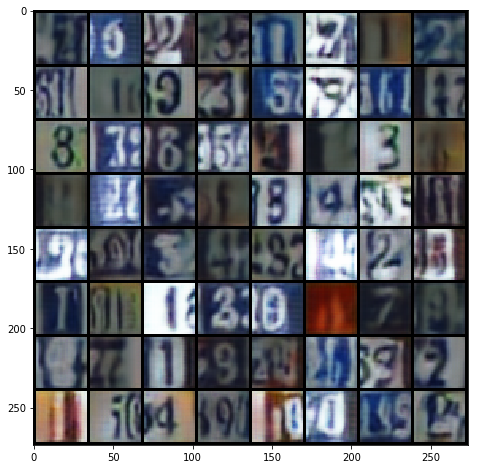

In [0]:
plt.figure(figsize=(8,8))
model.eval()
generator = netG
with torch.no_grad() :
    z_dim = 100
    bs    = 64
    mu    = torch.zeros(bs,z_dim)
    std   = torch.ones(bs,z_dim)
    z     = mu + 1.0 * std * torch.randn_like(std)
    z     = z.to(device)
    gen   = generator(z)
    gen_  = gen.cpu()
    # gen_  = gen_ - gen_.min()
    # gen_  = gen_ / gen_.max()
    # print(gen_.shape)
    # imshow(torchvision.utils.make_grid(gen_))
    grid_img = torchvision.utils.make_grid(gen_.cpu(), nrow=8, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))